# Angle Ply Laminate

---

This is an analysis of an *angle ply* ([-45, +45] degree) composite laminate plate.

In [1]:
from dfply import *
import grama as gr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Full DataFrame view
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from grama.models import make_composite_plate_tension
md_plate = make_composite_plate_tension([-np.pi/4, +np.pi/4])

In [2]:
md_plate.printpretty()

model: Composite Plate in Tension m45-p45

  inputs:
    var_det:
    var_rand:
      E1_0: (+0) lognorm, {'loc': 1, 's': 0.02, 'scale': 114000000000.0}
      E2_0: (+0) lognorm, {'loc': 1, 's': 0.08, 'scale': 7000000000.0}
      nu12_0: (+0) norm, {'loc': 0.45, 'scale': 0.12727922061357855}
      G12_0: (+0) lognorm, {'loc': 1, 's': 0.1, 'scale': 4000000000.0}
      theta_0: (+0) uniform, {'loc': -0.8377580409572781, 'scale': 0.10471975511965977}
      t_0: (+0) uniform, {'loc': 0.00099, 'scale': 2e-05}
      sigma_11_t_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 1400000000.0}
      sigma_22_t_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 1400000.0}
      sigma_11_c_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 500000000.0}
      sigma_22_c_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 500000.0}
      sigma_12_s_0: (-1) lognorm, {'loc': 1, 's': 0.07, 'scale': 62000000.0}
      E1_1: (+0) lognorm, {'loc': 1, 's': 0.02, 'scale': 114000000000.0}
      E2_1: (+0) lognorm, {'loc'

This model has a large number of random variables, but no deterministic variables.

### Discrepancy Analysis

---

*Design allowables* analysis.

In [3]:
p = 0.01
df_qe = md_plate >> \
    gr.ev_conservative(quantiles=p) >> \
    select(starts_with("g_")) >> \
    gather("limit", "g_da", everything())
df_qe

limit          g_da
0      g_11_tension_0  5.369998e+08
1      g_22_tension_0 -5.775133e+07
2  g_11_compression_0  1.115473e+09
3  g_22_compression_0  5.940380e+07
4        g_12_shear_0 -3.171076e+08
5      g_11_tension_1  5.369998e+08
6      g_22_tension_1 -5.775133e+07
7  g_11_compression_1  1.115473e+09
8  g_22_compression_1  5.940380e+07
9        g_12_shear_1 -3.171076e+08

Monte carlo analysis

In [4]:
def qt(x):
    return quant(x, p)

df_true = md_plate >> \
    gr.ev_monte_carlo(n=1e3, df_det="nom") >> \
    summarize_each([qt], *md_plate.out) >> \
    gather("limit", "g_true", everything()) >> \
    mutate(limit = str_replace(X.limit, "_qt", ""))
df_true

eval_monte_carlo() is rounding n...


limit        g_true
0  g_11_compression_1  9.028255e+08
1      g_11_tension_1  6.263254e+08
2      g_22_tension_0 -9.886160e+07
3        g_12_shear_1 -3.225705e+08
4  g_11_compression_0  8.795002e+08
5      g_22_tension_1 -9.719727e+07
6      g_11_tension_0  6.165320e+08
7  g_22_compression_0  9.613893e+06
8  g_22_compression_1  8.754979e+06
9        g_12_shear_0 -3.335508e+08

Join the two DataFrames and compute discrepancy.

In [5]:
df_discrepancy = \
    df_qe >> \
    inner_join( df_true, by="limit" ) >> \
    mutate(delta=X.g_true - X.g_da) >> \
    arrange(X.delta)
df_discrepancy

limit          g_da        g_true         delta
2  g_11_compression_0  1.115473e+09  8.795002e+08 -2.359731e+08
7  g_11_compression_1  1.115473e+09  9.028255e+08 -2.126478e+08
8  g_22_compression_1  5.940380e+07  8.754979e+06 -5.064882e+07
3  g_22_compression_0  5.940380e+07  9.613893e+06 -4.978991e+07
1      g_22_tension_0 -5.775133e+07 -9.886160e+07 -4.111027e+07
6      g_22_tension_1 -5.775133e+07 -9.719727e+07 -3.944594e+07
4        g_12_shear_0 -3.171076e+08 -3.335508e+08 -1.644320e+07
9        g_12_shear_1 -3.171076e+08 -3.225705e+08 -5.462920e+06
0      g_11_tension_0  5.369998e+08  6.165320e+08  7.953220e+07
5      g_11_tension_1  5.369998e+08  6.263254e+08  8.932556e+07

For the angle ply, the compression limit states are the most anti-conservative to analyze with design allowables.

### Sweep Analysis

---

Let's generate sinew data to begin exploring this model.

In [6]:
df_sweeps = md_plate >> \
    gr.ev_sinews(n_sweeps=10, df_det="nom")
df_sweeps.describe()


sigma_11_c_0          t_1      theta_1  sigma_12_s_1  sigma_11_t_1  \
count  2.300000e+03  2300.000000  2300.000000  2.300000e+03  2.300000e+03   
mean   5.136965e+08     0.000999     0.782288  6.038026e+07  1.391663e+09   
std    5.425062e+07     0.000005     0.023092  6.130937e+06  1.185665e+08   
min    1.000000e+00     0.000990     0.733038  1.000000e+00  1.000000e+00   
25%    4.949110e+08     0.000996     0.771168  5.891022e+07  1.338791e+09   
50%    5.040211e+08     0.000999     0.785400  6.173987e+07  1.399286e+09   
75%    5.372088e+08     0.001005     0.805602  6.365350e+07  1.453226e+09   
max    6.158476e+08     0.001010     0.837758  7.296492e+07  1.609709e+09   

       sigma_12_s_0            Nx          E1_0  sigma_22_t_1          E1_1  \
count  2.300000e+03  2.300000e+03  2.300000e+03  2.300000e+03  2.300000e+03   
mean   6.413733e+07  1.247741e+06  1.143845e+11  1.425572e+06  1.136314e+11   
std    4.944962e+06  1.313952e+05  7.729284e+09  1.298002e+05  7.793800e+09   
min    1.000000e+00  9.208383e+05  1.000000e+00  1.000000e+00  1.000000e+00   
25%    6.164453e+07  1.159999e+06  1.139445e+11  1.342451e+06  1.124314e+11   
50%    6.524708e+07  1.203149e+06  1.143457e+11  1.411324e+06  1.140004e+11   
75%    6.619361e+07  1.387973e+06  1.160843e+11  1.498324e+06  1.157725e+11   
max    7.296492e+07  1.479162e+06  1.194294e+11  1.609710e+06  1.194294e+11   

               E2_1         G12_1       nu12_0       nu12_1  sigma_11_t_0  \
count  2.300000e+03  2.300000e+03  2300.000000  2300.000000  2.300000e+03   
mean   6.999291e+09  4.007479e+09     0.387608     0.440801  1.399817e+09   
std    6.459927e+08  4.233054e+08     0.175483     0.128272  1.409640e+08   
min    1.000000e+00  1.000000e+00     0.110014     0.153904  1.000000e+00   
25%    6.723849e+09  3.924213e+09     0.296510     0.360800  1.316917e+09   
50%    6.942482e+09  3.971207e+09     0.384179     0.450000  1.377123e+09   
75%    7.410638e+09  4.116212e+09     0.432796     0.556235  1.527342e+09   
max    8.431865e+09  5.047682e+09     0.746096     0.746096  1.609709e+09   

       sigma_22_t_0          E2_0      theta_0  sigma_11_c_1   sigma_22_c_0  \
count  2.300000e+03  2.300000e+03  2300.000000  2.300000e+03    2300.000000   
mean   1.389132e+06  7.077995e+09    -0.791371  5.018498e+08  515326.800604   
std    1.154417e+05  7.624862e+08     0.026919  4.289544e+07   47534.230225   
min    1.000000e+00  1.000000e+00    -0.837758  1.000000e+00       1.000000   
25%    1.331304e+06  6.433453e+09    -0.812668  4.838352e+08  487505.466632   
50%    1.400050e+06  7.366506e+09    -0.795524  4.998719e+08  504388.211653   
75%    1.464571e+06  7.494120e+09    -0.772211  5.150493e+08  551241.343865   
max    1.609710e+06  8.431865e+09    -0.733038  5.748959e+08  574896.894214   

        sigma_22_c_1         G12_0          t_0    sweep_ind  g_11_tension_0  \
count    2300.000000  2.300000e+03  2300.000000  2300.000000    2.300000e+03   
mean   500155.291653  3.831008e+09     0.001000     4.500000    8.376198e+08   
std     44538.322018  3.735241e+08     0.000006     2.872906    1.533407e+08   
min         1.000000  1.000000e+00     0.000990     0.000000   -6.407162e+08   
25%    469646.324761  3.560600e+09     0.000996     2.000000    7.561626e+08   
50%    508993.434721  3.852083e+09     0.001000     4.500000    8.259866e+08   
75%    520652.949662  3.984572e+09     0.001005     7.000000    9.387463e+08   
max    574896.894214  5.047682e+09     0.001010     9.000000    1.564175e+09   

       g_22_tension_0  g_11_compression_0  g_22_compression_0  g_12_shear_0  \
count    2.300000e+03        2.300000e+03        2.300000e+03  2.300000e+03   
mean    -5.169775e+07        1.075894e+09        5.360220e+07 -2.426683e+08   
std      4.648116e+07        7.990244e+07        4.648309e+07  5.929724e+07   
min     -7.263263e+08        4.470180e+08       -2.957137e+07 -6.695486e+08   
25%     -6.559298e+07        1.037641e+09        2.378197e+07 -2.844679e+08   


Observations:

- Among the limit states (outputs)
  + The longitudinal (11) `tension` states are largely non-critical (positive)
  + The transverse (22) `tension` states and `shear` states are frequently critical (negative)
  
Note however that a sinew design is not a Monte Carlo; the design above is not drawn from the distribution. We can't read these quantiles as reflective of the true output distributions.
  
We can see a lot more qualitative behavior by visualizing the sweeps.


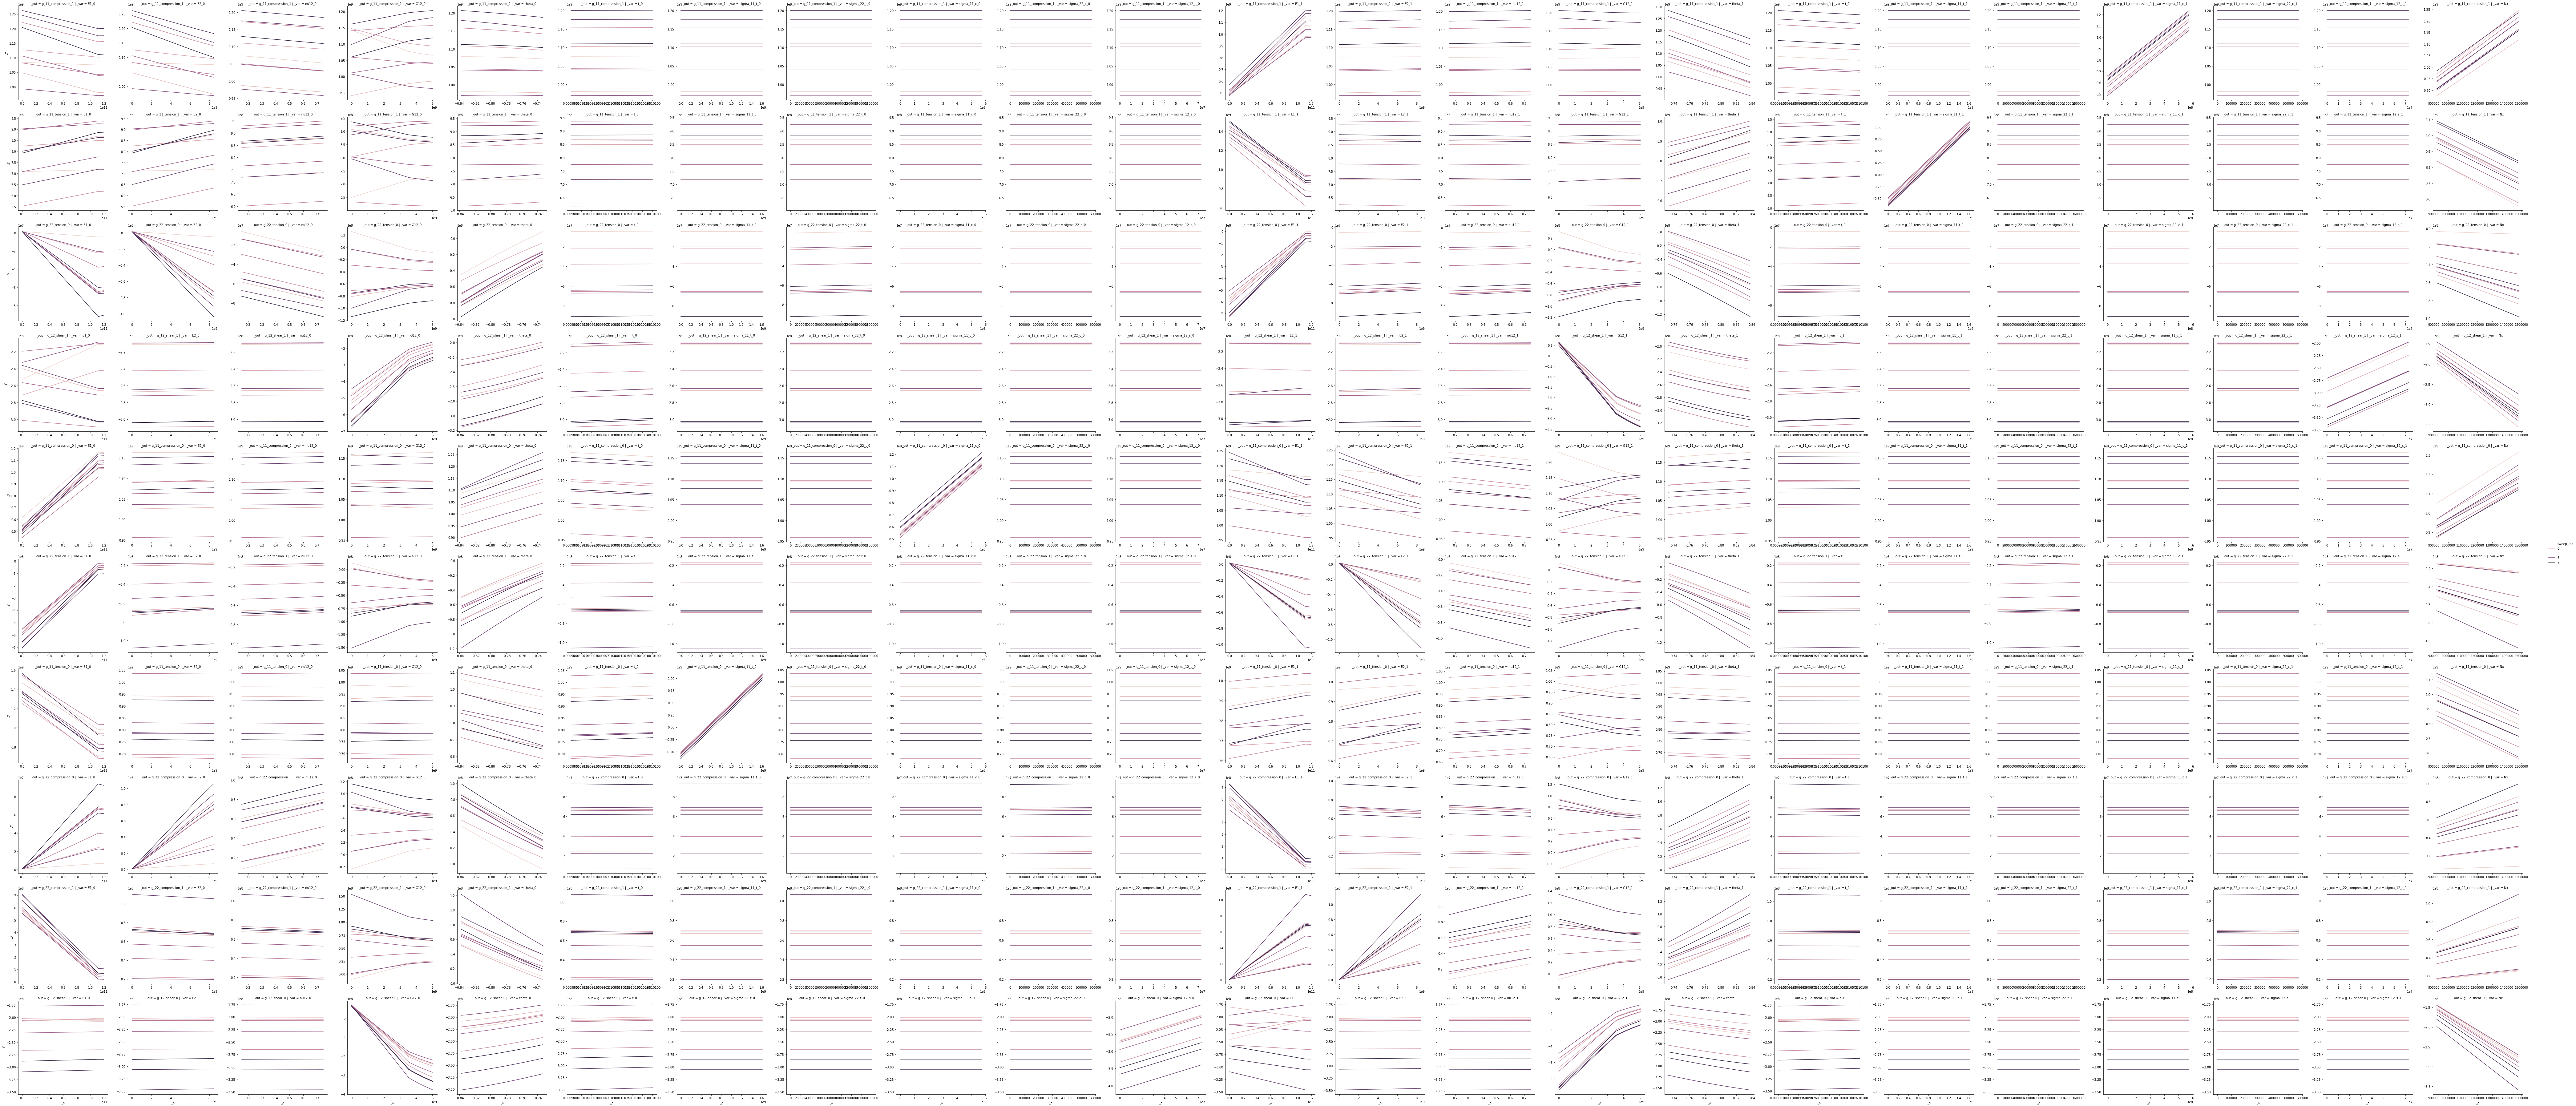

In [7]:
df_sweeps >> gr.pt_auto()
plt.savefig("./sweeps_full.png")


This full sinew plot is a bit overwhelming; I save a local copy for zooming. Observations:

- A number of the limit states are fairly nonlinear; it is difficult to tell which from the zoomed-out version.

Sinew plots can be useful for debugging a model during development; the following plot focuses on the limit states and critical stresses for a single ply. If the model is implemented correctly the effects should be *diagonal*, in the sense that each critical stress should only have an effect on its associated limit state. Furthermore, each effect should be linear with slope one.

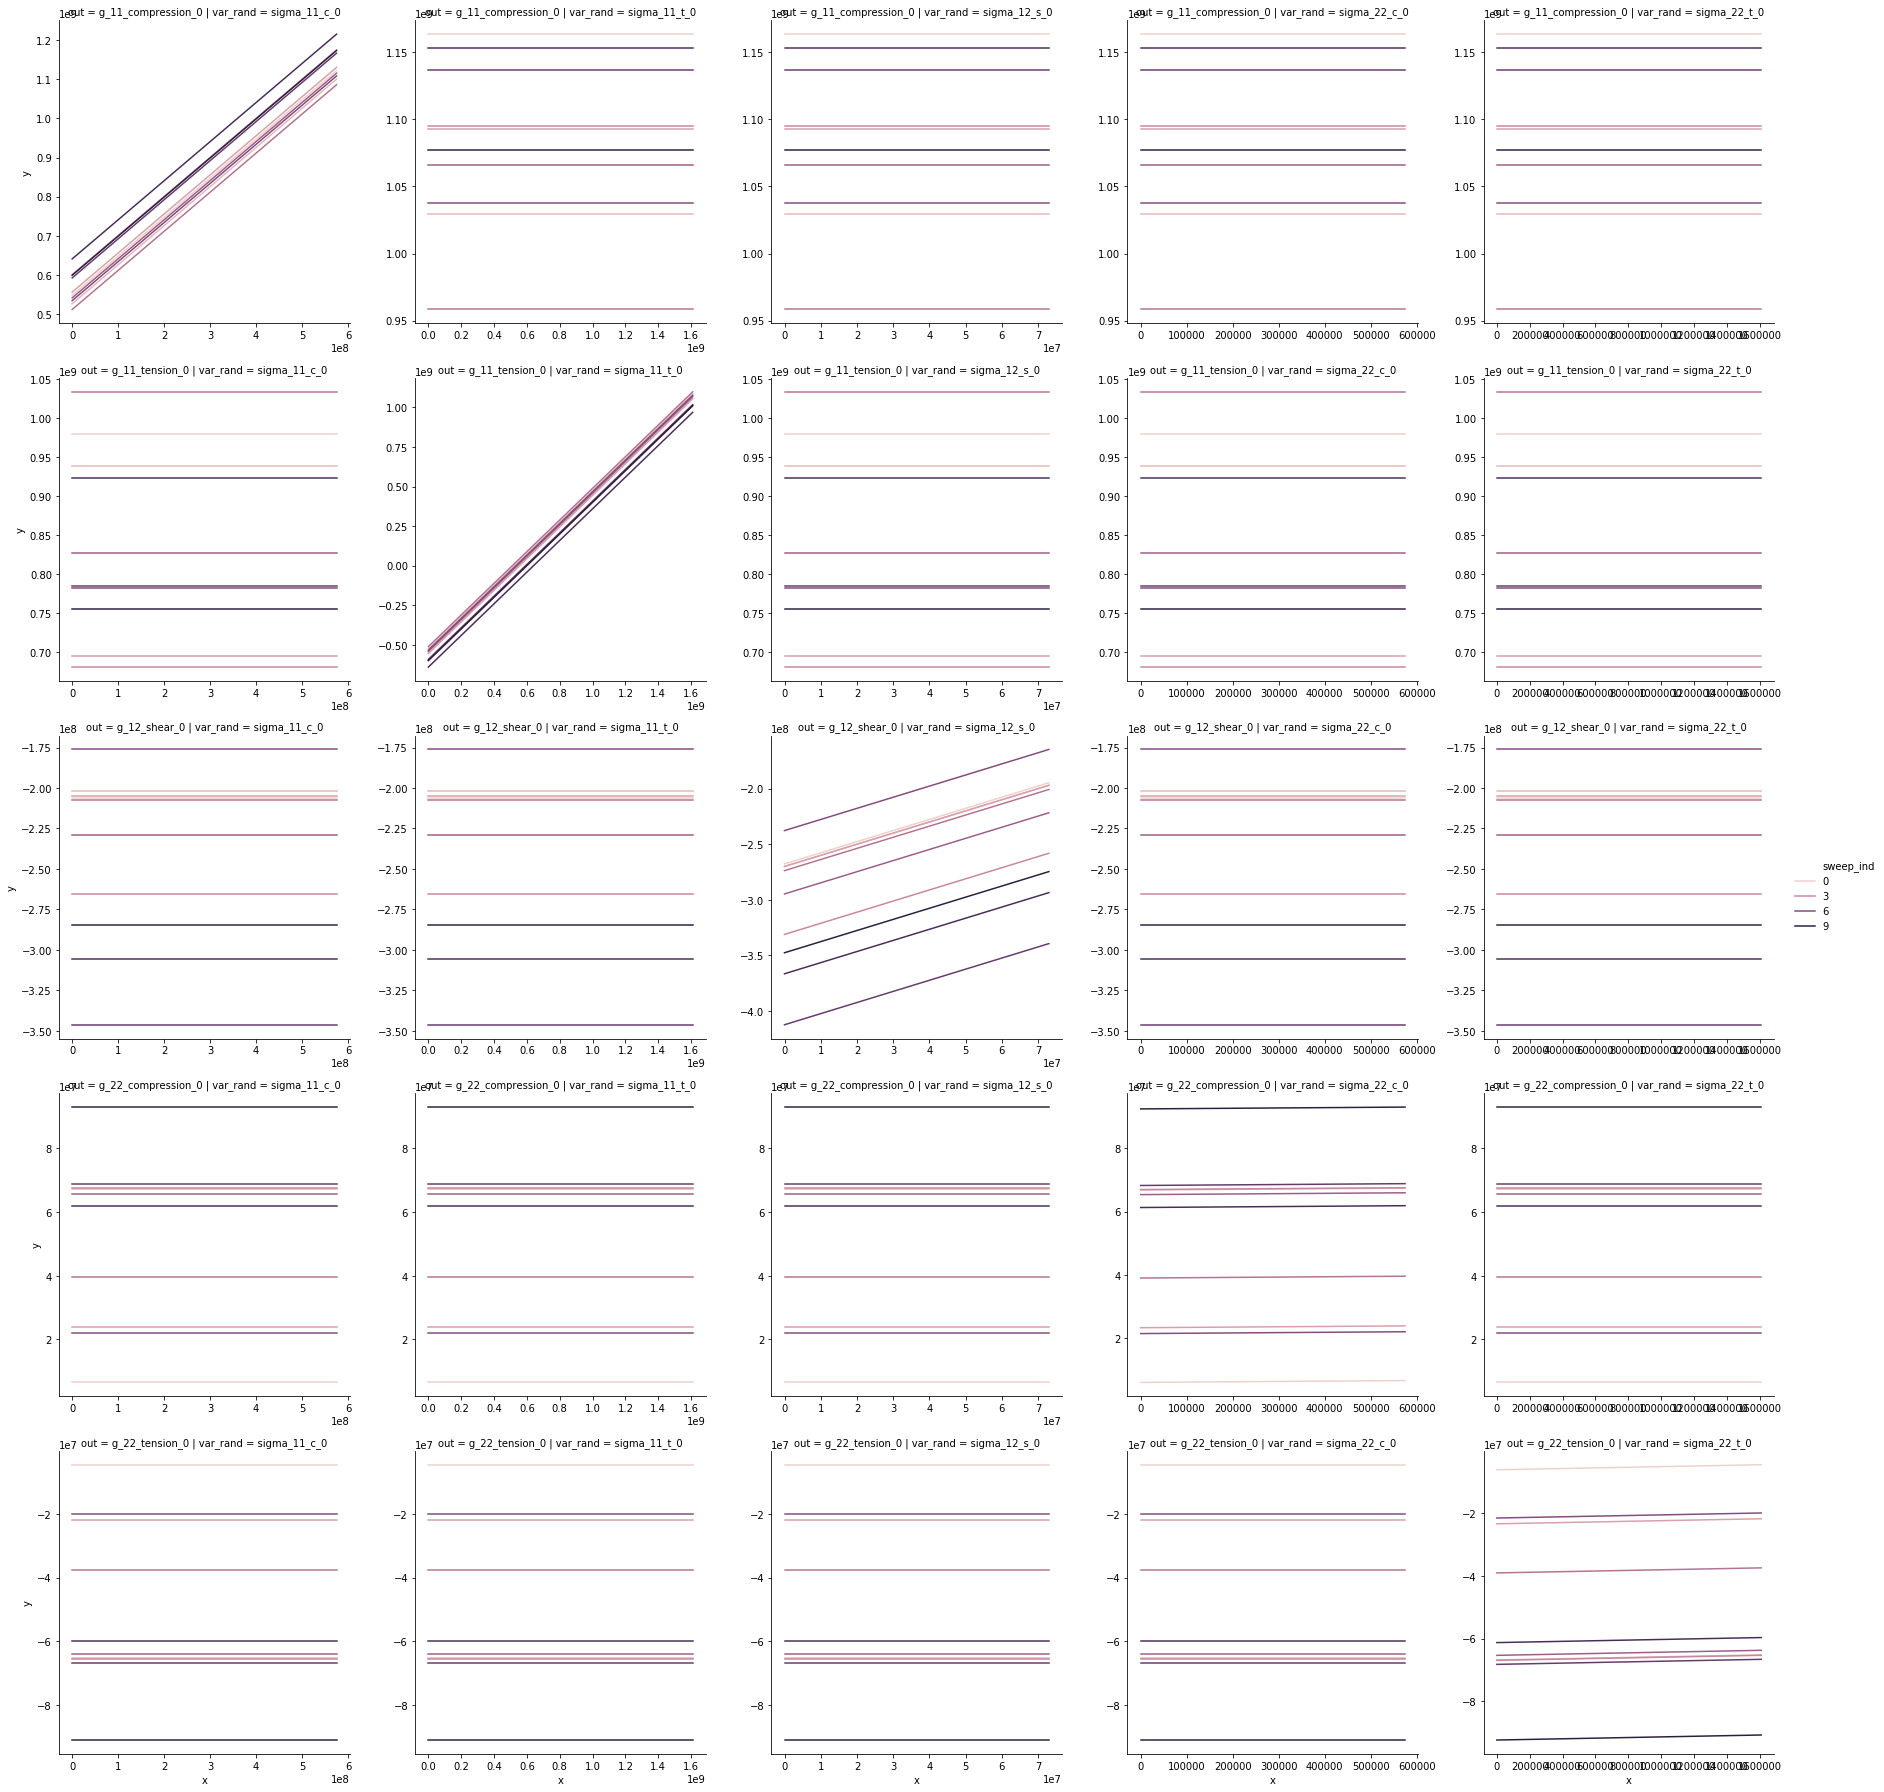

In [8]:
df_lam0 = \
    df_sweeps >> \
    gather("var_rand", "x", md_plate.var_rand) >> \
    gather("out", "y", md_plate.out) >> \
    mask(
        str_detect(X.var_rand, "sigma_\\w+_0") &
        str_detect(X.out, "g_\\w+_0") &
        (X.var_rand == X.sweep_var)
    ) >> \
    arrange(X.var_rand, X.out)

sns.relplot(
    data=df_lam0,
    x="x",
    y="y",
    hue="sweep_ind",
    col="var_rand",
    row="out",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False)
)

Here we can see the diagonal relationship, as expected.

From inspecting the full sinew plot, it appears the shear modulii `g_12_shear_i` have a strange cross-effect:

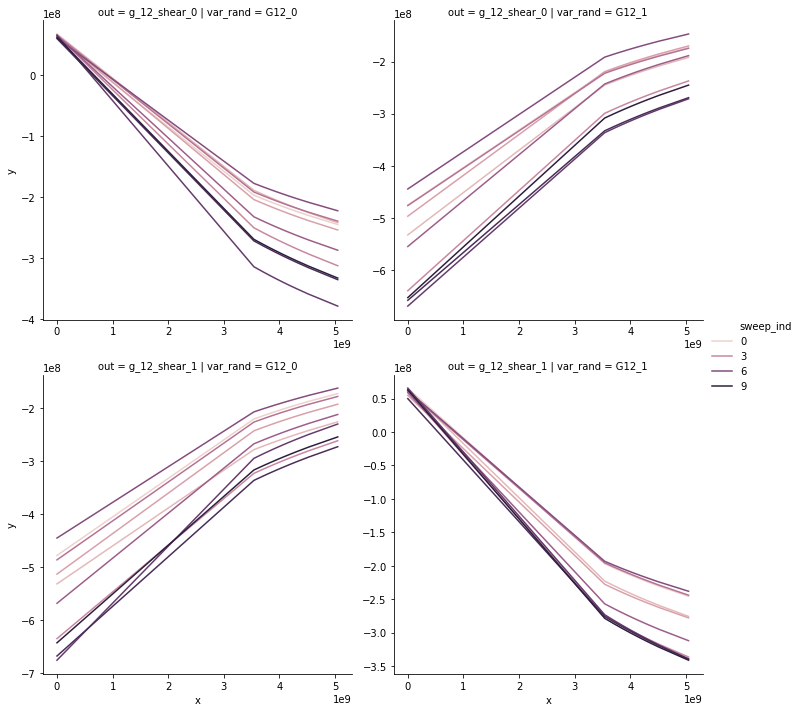

In [9]:
df_shear = \
    df_sweeps >> \
    gather("var_rand", "x", md_plate.var_rand) >> \
    gather("out", "y", md_plate.out) >> \
    mask(
        str_detect(X.var_rand, "G12_") &
        str_detect(X.out, "g_12_shear") &
        (X.var_rand == X.sweep_var)
    ) >> \
    arrange(X.var_rand, X.out)

sns.relplot(
    data=df_shear,
    x="x",
    y="y",
    hue="sweep_ind",
    col="var_rand",
    row="out",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False)
)

Observations:

- The shear modulus `g_12_shear_i` **decreases** the associated limit state `g_12_shear_i`
- The shear modulus `g_12_shear_i` **increases** the cross-associated limit state `g_12_shear_j`

Stiffening one ply causes that ply to take more of the total load, which reduces the load on the other ply. This explains the opposite effects observed above.

---

From close inspection of the full sinew plot, it appears the effect of certain variables switch across different sinews:

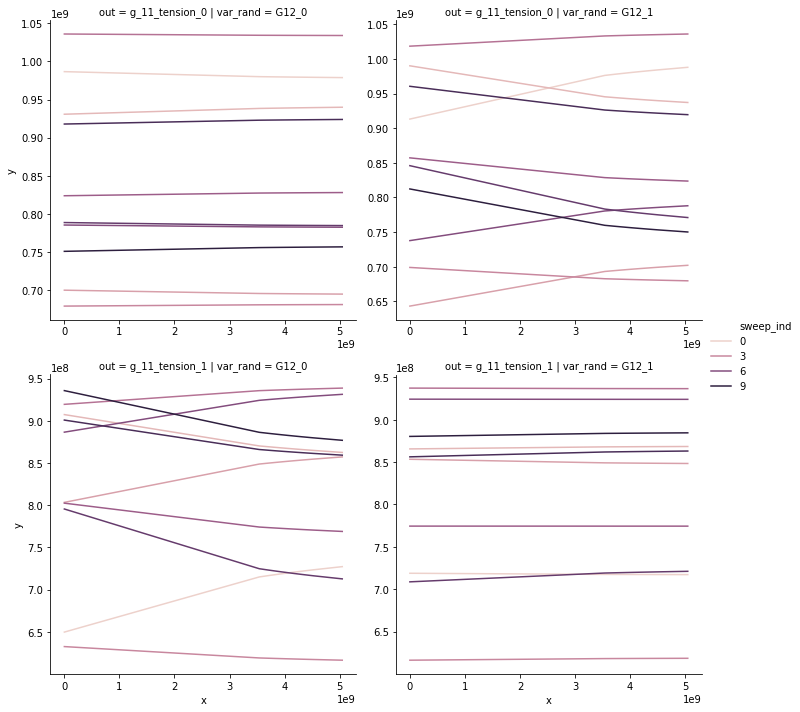

In [10]:
df_shear = \
    df_sweeps >> \
    gather("var_rand", "x", md_plate.var_rand) >> \
    gather("out", "y", md_plate.out) >> \
    mask(
        str_detect(X.var_rand, "G12_") &
        str_detect(X.out, "g_11_tension") &
        (X.var_rand == X.sweep_var)
    ) >> \
    arrange(X.var_rand, X.out)

sns.relplot(
    data=df_shear,
    x="x",
    y="y",
    hue="sweep_ind",
    col="var_rand",
    row="out",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False)
)

Here we can see the shear modulii `G12_i` have an effect on the opposite ply `tension` that can change in sign depending on the values of the other random variables. Thus the shear modulii have a **non-monotone** effect on the longitudinal tension limit state.